In [1]:
# Ensure tensorflow is available in the notebook kernel
%pip install tensorflow -q

import os
# import pickle
# import random
# import imageio
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
# import matplotlib.cm as cm
import matplotlib.pyplot as plt
# from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
# from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, roc_auc_score, classification_report
import tensorflow as tf
# from tensorflow import keras
from keras.utils import Sequence, to_categorical
from keras.optimizers import Adam
from keras import optimizers, metrics, layers, models, applications
# from keras.callbacks import ReduceLROnPlateau
from keras.models import load_model, Model, Sequential
# from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, GlobalAveragePooling2D, PReLU, Dropout, BatchNormalization
# from keras.applications import ResNet50

Note: you may need to restart the kernel to use updated packages.


In [2]:
# in this section, i have iterated through all the images in the covid and normal folder
# the images have been labelled if they are covid or normal, covid = 1 and normal = 0
# converted those images to RGB, then resize them and make them consistent size 
# turned those images into numpy arrays and printed their shape 
folder_path = r'C:\_Dhruti\Projects\data-visualisation-learning\data\raw'
types = ['covid', 'normal']

data = [] 
labels = []

for t in types:
    path = os.path.join(folder_path, t)
    label = 1 if t == 'covid' else 0
    for img_name in os.listdir(path):
        img_path = os.path.join(path, img_name)
        # print (img_path) 
        img = Image.open(img_path).convert('RGB')           # ensures 3 channels because not everytime there wil be RGB 
        img = img.resize((224, 224))                        # resizing to make it consistent 
        img_array = np.array(img) / 255.0                   # converting to array and normalizing
        data.append(img_array)                              # saving the image data
        labels.append(label)                                # saving the label 

data = np.array(data)
labels = np.array(labels)
print (f"Data shape: {data.shape},\n Labels shape: {labels.shape}")

Data shape: (94, 224, 224, 3),
 Labels shape: (94,)


In [3]:
# in this section, i have broken the data into 2 sets - train set and test set using
# the train_test_split function from sklearn
# and then convert the labels to categorise into 2 classes - covid and normal using to_categorical function from keras 
X_train, X_test, Y_train, Y_test = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)  # previous line was to split the dataset into train and test sets 
print("training data shape: ", X_train.shape)
print("test data shape: ", X_test.shape)

y_train_category = to_categorical(Y_train, num_classes=2)
y_test_category = to_categorical(Y_test, num_classes=2)

print(y_train_category[:5])

training data shape:  (75, 224, 224, 3)
test data shape:  (19, 224, 224, 3)
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]


| Note                                  | Code Part                                     |
| ------------------------------------- | --------------------------------------------- |
| 2–3 Conv2D layers → ReLU → MaxPooling | The three Conv2D + MaxPooling2D blocks        |
| Flatten → Dense → Output              | `Flatten() → Dense(128) → Dropout → Dense(1)` |
| Binary classification                 | `Dense(1, activation='sigmoid')`              |
| Start simple                          | This is a small, beginner-friendly CNN        |


In [33]:
# model architecture is defined 
model = Sequential([
    
    # Conv2D is the convolutional block; there are 32 filters #applied 3x3 to scan he image to the input shape 224x2224x3
    # relu makes the convolutional layer output non-negative and non-linear
    # input shape is from teh shape of data/images i have
    # First convolutional block
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    # the (3,3) is the kernel size which determines the size of the filter applied to the input image,
    # in the input shape, 224 is the height and width of the image, and 3 is the number of color channels (RGB)

    MaxPooling2D((2,2)),
    # MaxPooling2D is the pooling layer which reduces the spatial dimensions of the feature maps by half 
    # halving the dimensions helps to reduce the number of parameters and computation in the model, which can help prevent overfitting and improve generalization
    # overfitting model means that the model performs well on the training data but poorly on unseen data
    # first convolutional block is the first layer of the model which extracts low-level features from the input images, such as edges and textures.

    # second and third convolutional blocks are deeper layers that extract more complex features, 
    # such as shapes and patterns, which are important for distinguishing between covid and normal images.
    # Second convolutional block
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    
    # Third convolutional block
    # Conv2D(128, (3,3), activation='relu'),
    # MaxPooling2D((2,2)),
    
    # Fourth convolutional block (for testing only - can remove later)
    # Conv2D(256, (3,3), activation='relu'),
    # MaxPooling2D((2,2)),


    # Flatten and fully connected layers
    Flatten(),
    # flatten function will convert the 3D feature maps into a 1D vector, which can be fed into the fully connected layers for classification.
    Dense(128, activation='relu'),
    Dropout(0.5),  # prevents overfitting
    # Dense and Dropout 
    # Dense means fully connected to flatten features - 128 neurons 
    # Dropout means randomly disables 50% of neurons during training -- prevents overfitting 
    # memorizing the training data instead of learning general patterns, which can lead to poor performance on unseen data.

    Dense(1, activation='sigmoid')  # binary classification
    # this dense has 1 layer which means it will output single value (binary classification) 
    # and sigmoid is outputting 1 or 0 which determines COVID or NORMAL 
    # sigmoid --> >= 0.5 then classified as COVID else NORMAL
])

In [34]:
# how the model should learn 
model.compile(
    optimizer=Adam(learning_rate=0.000001), # reducing this will decrease the model's confidence when it calls a normal image as covid
    loss='binary_crossentropy',   # for 2-class problems
    metrics=['accuracy']
)
# this means how the model should learn 
# Adam in optimizer is the adaptive gradient optimizer 
# learning rate means how big the weight setup is, too big or too small will result in unstable or slow learning
# loss function measures how wrong the model is 
# binary crossentropy is used for binary classification problems (for e.g. here covid or normal)
# metrics is used to evaluate accuracy

In [35]:
# how the model is trained 
history = model.fit(
    X_train, Y_train,           # training data
    validation_data=(X_test, Y_test),
    epochs=5,                  # start small; increase later
    batch_size=16               # adjust based on memory
)
# For each epoch, the model will take 16 images, make predictions, calculate loss, updates weight using adam
# this repeats until all training images are used. 
# Validation_data means the model tests itself on unseen data
# epochs means the model sees entire dataset 10 times 
# batch_size means feeding 16 images at a time, otherwise too muchh memory will be consumed and it might crash  

Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.6933 - loss: 0.6232 - val_accuracy: 0.7368 - val_loss: 0.5795
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.7200 - loss: 0.5562 - val_accuracy: 0.7368 - val_loss: 0.5518
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.7333 - loss: 0.5166 - val_accuracy: 0.7368 - val_loss: 0.5406
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.7333 - loss: 0.5408 - val_accuracy: 0.7368 - val_loss: 0.5274
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.7333 - loss: 0.5184 - val_accuracy: 0.7368 - val_loss: 0.5148


In [36]:
loss, accuracy = model.evaluate(X_test, Y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7368 - loss: 0.5148
Test Accuracy: 73.68%


In [8]:
def preprocess_image(image_path):
    img = Image.open(image_path).convert('RGB')
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    
    # Add batch dimension (VERY IMPORTANT)
    img_array = np.expand_dims(img_array, axis=0)
    
    return img_array


def predict_image(image_path):
    processed_image = preprocess_image(image_path)
    
    prediction = model.predict(processed_image)
    
    probability = prediction[0][0]
    
    if probability >= 0.5:
        print(f"Prediction: COVID ({probability*100:.2f}% confidence)")
    else:
        print(f"Prediction: NORMAL ({(1-probability)*100:.2f}% confidence)")


In [9]:
# predict_image(r"C:\_Dhruti\Projects\data-visualisation-learning\data\processed\23E99E2E-447C-46E5-8EB2-D35D12473C39.png")

predict_image(r"C:\_Dhruti\Projects\data-visualisation-learning\data\processed\normal-chest-x-ray-620x400.webp")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Prediction: COVID (72.22% confidence)


In [10]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
early_stop

In [11]:
inputs = layers.Input(shape=(224, 224, 3))

x = layers.Conv2D(32, (3,3), activation='relu', name="last_conv")(inputs)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs, outputs)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


def preprocess_image(image_path):
    img = Image.open(image_path).convert("RGB")
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # add batch dimension
    return img_array.astype(np.float32)

def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[
            model.get_layer(last_conv_layer_name).output,
            model.output
        ]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)

    heatmap = tf.maximum(heatmap, 0)

    # Avoid divide-by-zero
    max_val = tf.reduce_max(heatmap)
    if max_val > 0:
        heatmap /= max_val

    return heatmap.numpy()

def display_gradcam(image_path):
    
    # Ensure model is built (important if notebook restarted)
    model(np.zeros((1, 224, 224, 3)))
    
    img_array = preprocess_image(image_path)

    heatmap = make_gradcam_heatmap(
        img_array,
        model,
        last_conv_layer_name="last_conv"
    )

    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))

    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed = heatmap * 0.4 + img

    plt.figure(figsize=(6,6))
    plt.imshow(cv2.cvtColor(superimposed.astype("uint8"), cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

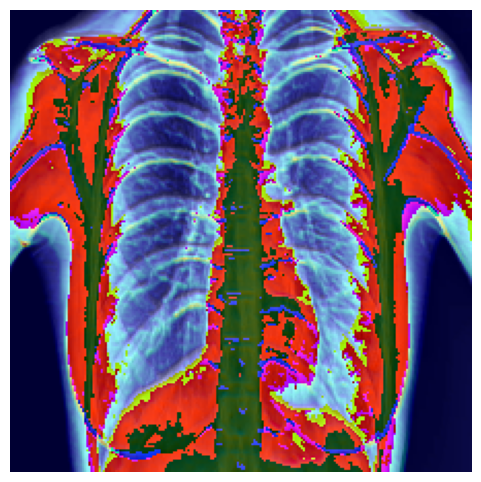

In [12]:
display_gradcam("C:/_Dhruti/Projects/data-visualisation-learning/data/processed/normal-chest-x-ray-620x400.webp")


In [13]:
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))

{np.int64(0): np.int64(25), np.int64(1): np.int64(69)}


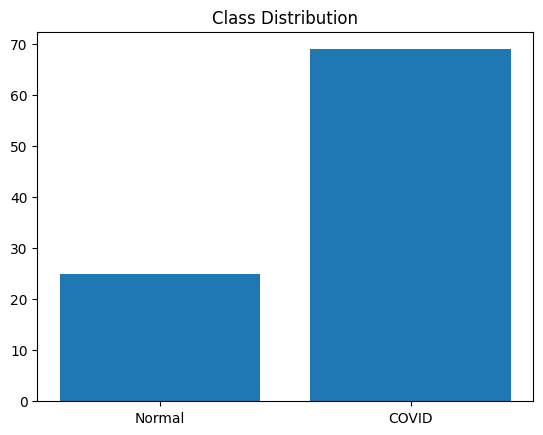

In [14]:
plt.bar(['Normal', 'COVID'], counts)
plt.title("Class Distribution")
plt.show()

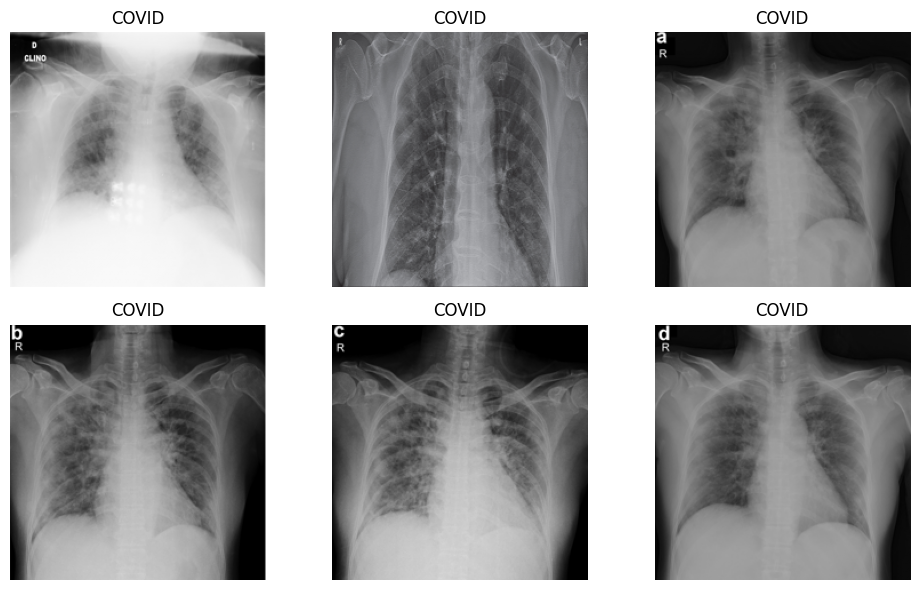

In [15]:
plt.figure(figsize=(10,6))

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(data[i])
    plt.title("COVID" if labels[i]==1 else "NORMAL")
    plt.axis('off')

plt.tight_layout()
plt.show()


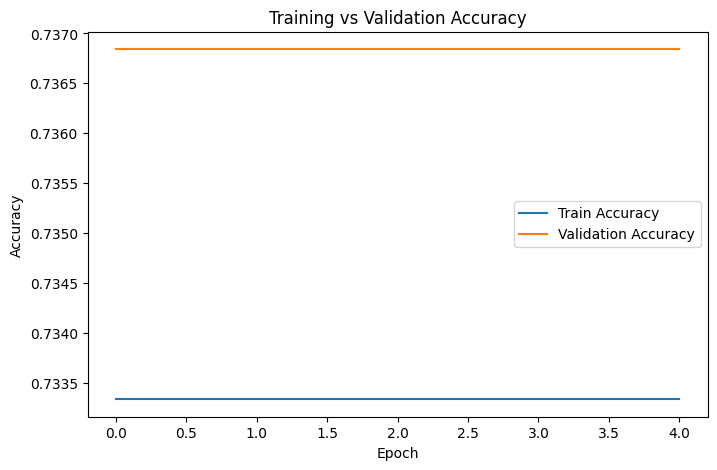

In [16]:
plt.figure(figsize=(8,5))

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()


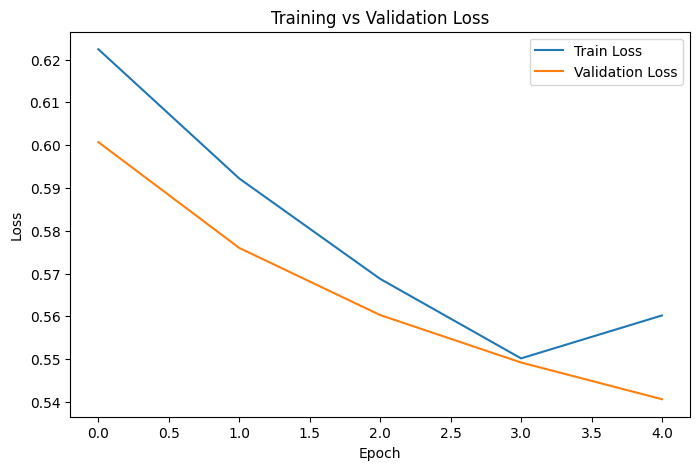

In [17]:
plt.figure(figsize=(8,5))

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()


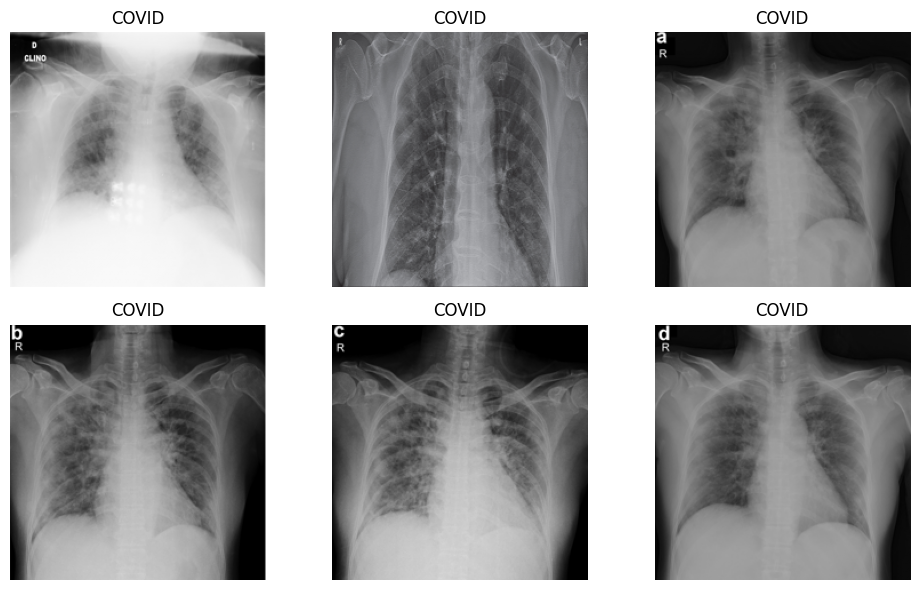

In [18]:
plt.figure(figsize=(10,6))

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(data[i])
    plt.title("NORMAL" if labels[i]==0 else "COVID")
    plt.axis('off')

plt.tight_layout()
plt.show()
